In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from src.dataset import NeighborDataset
from torch.utils.data import DataLoader
from src.qpath import linspace_2D_equidistant
import numpy as np
import torch
from src.kernel import L_Kernel
from src.sqw import SpecNeuralRepr
import os

torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Only need to specify ckpt_path and synthetic data or not

For experimental data, used: "/pscratch/sd/z/zhantao/yuan/pscratch/sd/y/yn754/data/S2e/checkpoints/synthetic_nr2_bkw5e-04_tvw0e+00/kernel_model-epoch=22-val_loss=0.0000.ckpt"
For synthetic data, used: "/pscratch/sd/z/zhantao/yuan/pscratch/sd/y/yn754/data/S2e/checkpoints/synthetic_v1_nr3_bkw5e-03_tvw0e+00/kernel_model-epoch=27-val_loss=0.0000.ckpt"

In [ ]:
ckpt_path = "/pscratch/sd/z/zhantao/yuan/pscratch/sd/y/yn754/data/S2e/checkpoints/synthetic_nr2_bkw5e-04_tvw0e+00/kernel_model-epoch=22-val_loss=0.0000.ckpt"
synthetic = False

# ckpt_path = "/pscratch/sd/z/zhantao/yuan/pscratch/sd/y/yn754/data/S2e/checkpoints/synthetic_v1_nr2_bkw5e-04_tvw0e+00/kernel_model-epoch=22-val_loss=0.0000.ckpt"
# synthetic = True

Load trained model

In [ ]:
### load data and forward model##########
if synthetic:
    data_path = '/pscratch/sd/z/zhantao/yuan/pscratch/sd/y/yn754/data/S2e/summarized_neutron_data_w_bkg_260meV_synthetic_J32.00_Jp-2.60.pt' #synthetic data
else:
    data_path = '/pscratch/sd/z/zhantao/yuan/pscratch/sd/y/yn754/data/S2e/summarized_neutron_data_w_bkg_260meV_ML.pt' #experimental data

data_dict = torch.load(data_path,weights_only=False)
print(data_dict.keys())


### forward model########################
best_ckpt = '/pscratch/sd/z/zhantao/yuan/pscratch/sd/y/yn754/data/S2e/input/version_14896845/checkpoints/epoch=7160-step=343728.ckpt' #checkpoint for forward model
model_sqw0 = SpecNeuralRepr.load_from_checkpoint(best_ckpt,map_location=torch.device('cpu')).to(device) #specify forward model
if synthetic:
    model_sqw0.params = torch.tensor([32, -2.6])
else:
    model_sqw0.params = torch.tensor([29, 1.7])
#########################################

### load from new checkpoint ##########
model = L_Kernel.load_from_checkpoint(ckpt_path,forward_model = model_sqw0,map_location=torch.device('cpu')).to(device)
model_sqw = model.forward_model 

config = torch.load(ckpt_path,map_location=torch.device('cpu'))['hyper_parameters']
model_config = torch.load(ckpt_path,map_location=torch.device('cpu'))['hyper_parameters']['model_config']
model.load_state_dict(torch.load(ckpt_path,map_location=torch.device('cpu'))['state_dict'])

hklw_grid = torch.vstack([_.unsqueeze(0) for _ in torch.meshgrid(*[v for k, v in data_dict['grid'].items()], indexing='ij')]).permute(1, 2, 3, 4, 0)
dataset = NeighborDataset(hklw_grid, data_dict['S'], neighbor_range=model_config['neighbor_range'])
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
batch = next(iter(dataloader))


kpts = torch.from_numpy(linspace_2D_equidistant([[0,0],[0.5,0],[0.5,0.5],[0,0]], 100))
wpts = data_dict['grid']['w_grid']
qw_coords = []
for _l in data_dict['grid']['l_grid']:
    _qw_coords = torch.cat([
        kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
        _l * torch.ones(wpts.shape[0], kpts.shape[0], 1),
        wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
       ], dim=2)
    qw_coords.append(_qw_coords)
    
_l = data_dict['grid']['l_grid'][0]
center_pts = torch.vstack([_.unsqueeze(0) for _ in qw_coords])

#path to data
if synthetic:
    data_path = f'plots/synthetic_v1_nr_{config["model_config"]["neighbor_range"]}_bkw{config["loss_bkg_mag_weight"]}/'
else:
    data_path = f'plots/nr_{config["model_config"]["neighbor_range"]}_bkw{config["loss_bkg_mag_weight"]}/'

dict_keys(['grid', 'S', 'background', 'background_dict'])


/tmp/ipykernel_1735099/265521195.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  config = torch.load(ckpt_path,map_location=torch.device('cpu'))['hyper_parameters']
/tm

In [25]:
#load processed data
data = np.load(os.path.join(data_path, 'data_arrays.npz'))

# Access individual arrays
s_bkg_2d = data['s_bkg_2d']
s_sig_2d = data['s_sig_2d']
s_sim_2d = data['s_sim_2d']
s_exp_2d = data['s_exp_2d']
s_exp_full_2d = data['s_exp_full_2d']
s_sim_full_2d = data['s_sim_full_2d']
s_bkg_full_2d = data['s_bkg_full_2d']
s_sig_full_2d = data['s_sig_full_2d']

Plotting

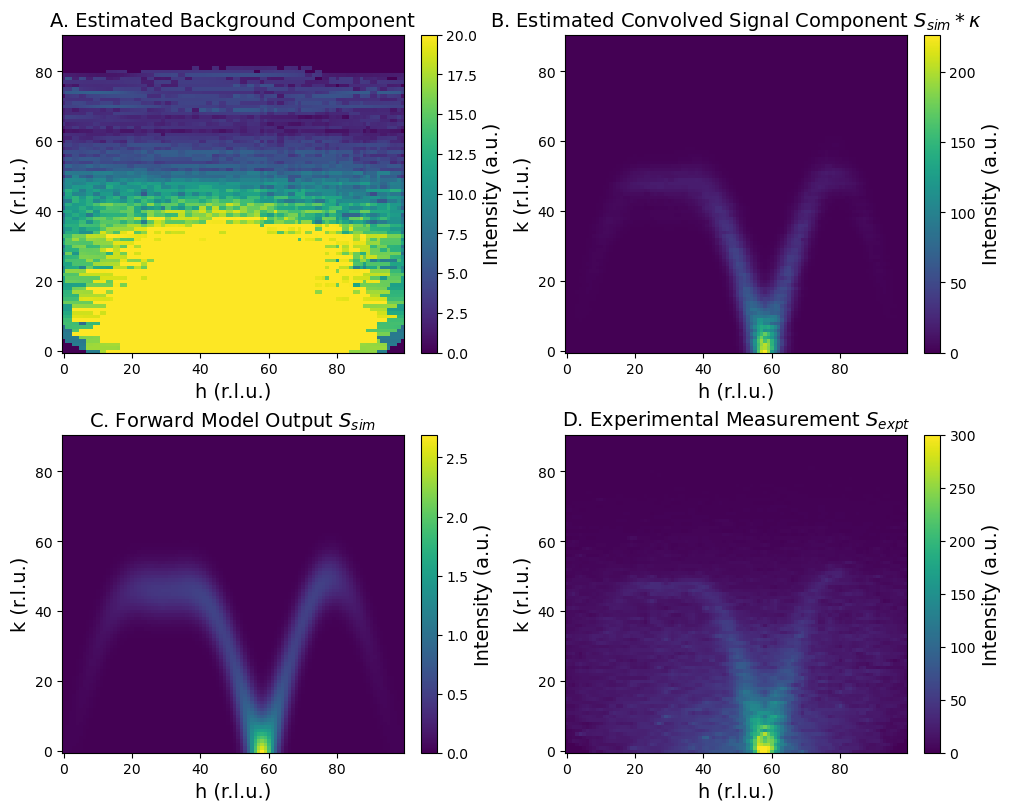

In [17]:
import matplotlib.pyplot as plt

# Choose perceptually uniform colormap suitable for scattering data
cmap = "viridis"

fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)

# Panel A: Background component
im0 = axes[0, 0].imshow(
    s_bkg_2d.sum(0),
    origin='lower', aspect='auto', vmax=20, cmap=cmap
)
axes[0, 0].set_title("A. Estimated Background Component", fontsize=14)
axes[0, 0].set_xlabel("h (r.l.u.)", fontsize=14)
axes[0, 0].set_ylabel("k (r.l.u.)", fontsize=14)
cbar0 = fig.colorbar(im0, ax=axes[0, 0])
cbar0.set_label("Intensity (a.u.)", fontsize=14)

# Panel B: Signal component
im1 = axes[0, 1].imshow(
    s_sig_2d.sum(0),
    origin='lower', aspect='auto', cmap=cmap
)
axes[0, 1].set_title(r"B. Estimated Convolved Signal Component $S_{sim} * \kappa$", fontsize=14)
axes[0, 1].set_xlabel("h (r.l.u.)", fontsize=14)
axes[0, 1].set_ylabel("k (r.l.u.)", fontsize=14)
cbar1 = fig.colorbar(im1, ax=axes[0, 1])
cbar1.set_label("Intensity (a.u.)", fontsize=14)

# Panel C: Forward model output
im2 = axes[1, 0].imshow(
    model_sqw.forward_qw(center_pts.to(model_sqw.device)).cpu().sum(0),
    origin='lower', aspect='auto', cmap=cmap
)
axes[1, 0].set_title(r"C. Forward Model Output $S_{sim}$", fontsize=14)
axes[1, 0].set_xlabel("h (r.l.u.)", fontsize=14)
axes[1, 0].set_ylabel("k (r.l.u.)", fontsize=14)
cbar2 = fig.colorbar(im2, ax=axes[1, 0])
cbar2.set_label("Intensity (a.u.)", fontsize=14)

# Panel D: Experimental data
im3 = axes[1, 1].imshow(s_exp_2d, origin='lower', aspect='auto', vmax=300, cmap=cmap)
axes[1, 1].set_title(r"D. Experimental Measurement $S_{expt}$", fontsize=14)
axes[1, 1].set_xlabel("h (r.l.u.)", fontsize=14)
axes[1, 1].set_ylabel("k (r.l.u.)", fontsize=14)
cbar3 = fig.colorbar(im3, ax=axes[1, 1])
cbar3.set_label("Intensity (a.u.)", fontsize=14)

# Optional: Main title
# fig.suptitle("Scattering Signal Decomposition in Reciprocal Space", fontsize=14)

# # Save in publication-ready format
# plt.savefig("scattering_decomposition_hk.png", dpi=300, bbox_inches='tight')
# plt.savefig("scattering_decomposition_hk.pdf", bbox_inches='tight')

plt.show()


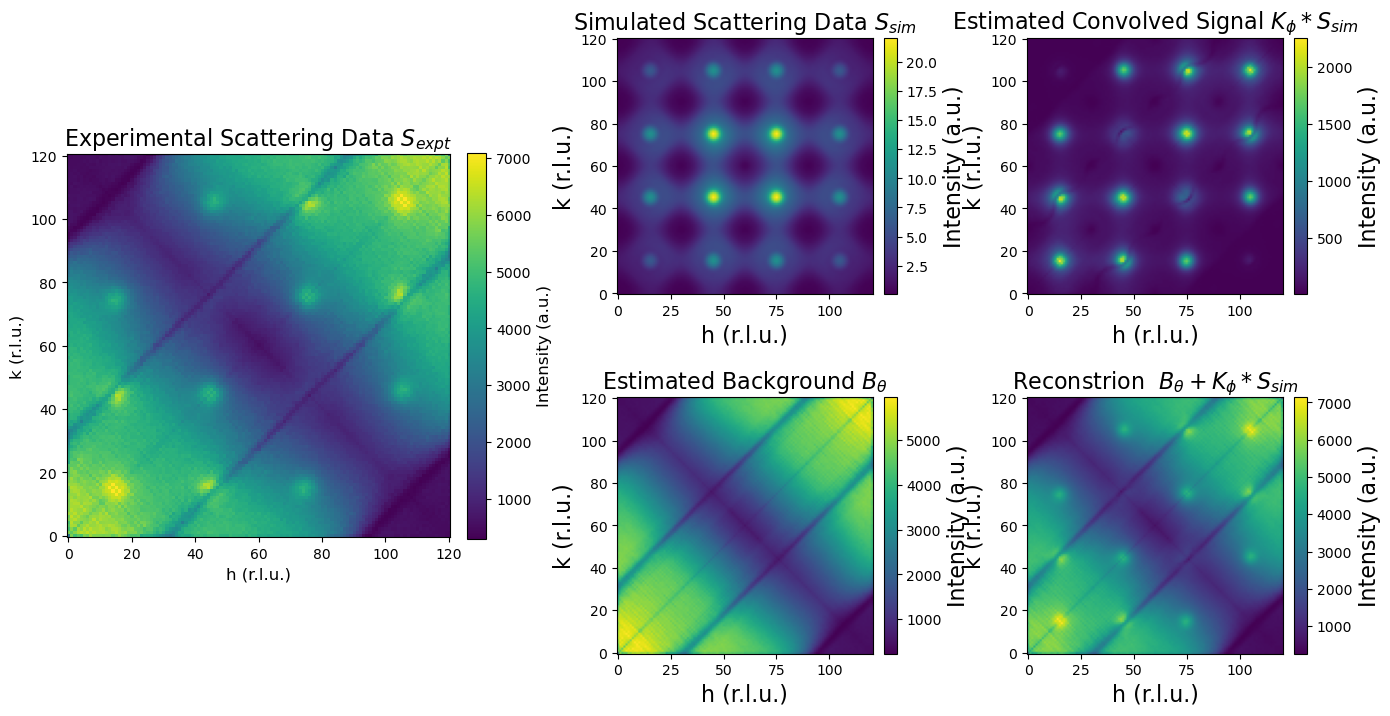

In [14]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Prepare the 2D arrays by reshaping and summing over the last two axes.
S_expt_plot = s_exp_full_2d.sum(-1).sum(-1)
S_sim_plot  = s_sim_full_2d.sum(-1).sum(-1)
S_sig_plot  = s_sig_full_2d.sum(-1).sum(-1)
S_bkg_plot  = s_bkg_full_2d.sum(-1).sum(-1)
recon_plot  = (s_sig_full_2d + s_bkg_full_2d).sum(-1).sum(-1)

# Create a figure with a 2-row x 3-column GridSpec.
# The first column (spanning both rows) will host the large experimental plot.
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(nrows=2, ncols=3, width_ratios=[1.5, 1, 1], wspace=0.4, hspace=0.4)

# Big left panel: Experimental Scattering Data (spanning both rows)
ax_main = fig.add_subplot(gs[:, 0])
im_main = ax_main.imshow(S_expt_plot, origin='lower', aspect='auto', cmap='viridis')
ax_main.set_title(r"Experimental Scattering Data $S_{expt}$", fontsize=16)
ax_main.set_xlabel("h (r.l.u.)", fontsize=12)
ax_main.set_ylabel("k (r.l.u.)", fontsize=12)
cbar_main = plt.colorbar(im_main, ax=ax_main, fraction=0.046, pad=0.04)
cbar_main.set_label("Intensity (a.u.)", fontsize=12)

# Compute the aspect ratio from the image data (height / width)
aspect_ratio = S_expt_plot.shape[0] / S_expt_plot.shape[1]
# Try to set the axis box aspect to preserve the original image proportions
try:
    ax_main.set_box_aspect(aspect_ratio)
except Exception:
    ax_main.set_aspect(aspect_ratio)
# Center the axis content within its allocated grid cell
ax_main.set_anchor('C')

# Top-middle panel: Simulated Scattering Data S_sim
ax1 = fig.add_subplot(gs[0, 1])
im1 = ax1.imshow(S_sim_plot, origin='lower', aspect='auto', cmap='viridis')
ax1.set_title(r"Simulated Scattering Data $S_{sim}$", fontsize=16)
ax1.set_xlabel("h (r.l.u.)", fontsize=16)
ax1.set_ylabel("k (r.l.u.)", fontsize=16)
cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label("Intensity (a.u.)", fontsize=16)

# Top-right panel: Estimated Convolved Signal Component
ax2 = fig.add_subplot(gs[0, 2])
im2 = ax2.imshow(S_sig_plot, origin='lower', aspect='auto', cmap='viridis')
ax2.set_title(r"Estimated Convolved Signal $K_\phi * S_{sim}$", fontsize=16)
ax2.set_xlabel("h (r.l.u.)", fontsize=16)
ax2.set_ylabel("k (r.l.u.)", fontsize=16)
cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
cbar2.set_label("Intensity (a.u.)", fontsize=16)

# Bottom-middle panel: Estimated Background Component
ax3 = fig.add_subplot(gs[1, 1])
im3 = ax3.imshow(S_bkg_plot, origin='lower', aspect='auto', cmap='viridis')
ax3.set_title(r"Estimated Background $B_{\theta}$", fontsize=16)
ax3.set_xlabel("h (r.l.u.)", fontsize=16)
ax3.set_ylabel("k (r.l.u.)", fontsize=16)
cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
cbar3.set_label("Intensity (a.u.)", fontsize=16)

# Bottom-right panel: Reconstructed $S_{expt}$ = s_bkg + s_sig
ax4 = fig.add_subplot(gs[1, 2])
im4 = ax4.imshow(recon_plot, origin='lower', aspect='auto', cmap='viridis')
ax4.set_title(r"Reconstrion  $B_\theta + K_\phi * S_{sim}$", fontsize=16)
ax4.set_xlabel("h (r.l.u.)", fontsize=16)
ax4.set_ylabel("k (r.l.u.)", fontsize=16)
cbar4 = plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)
cbar4.set_label("Intensity (a.u.)", fontsize=16)

# # Save the composite figure using filenames based on your configuration.
# filename = f'composite_2row3col_nr{config["model_config"]["neighbor_range"]}_bkw{config["loss_bkg_mag_weight"]}_tvw{config["loss_bkg_TV_weight"]}'
# plt.savefig(f'{filename}.png', dpi=300, bbox_inches='tight')
# plt.savefig(f'{filename}.pdf', bbox_inches='tight')
plt.show()


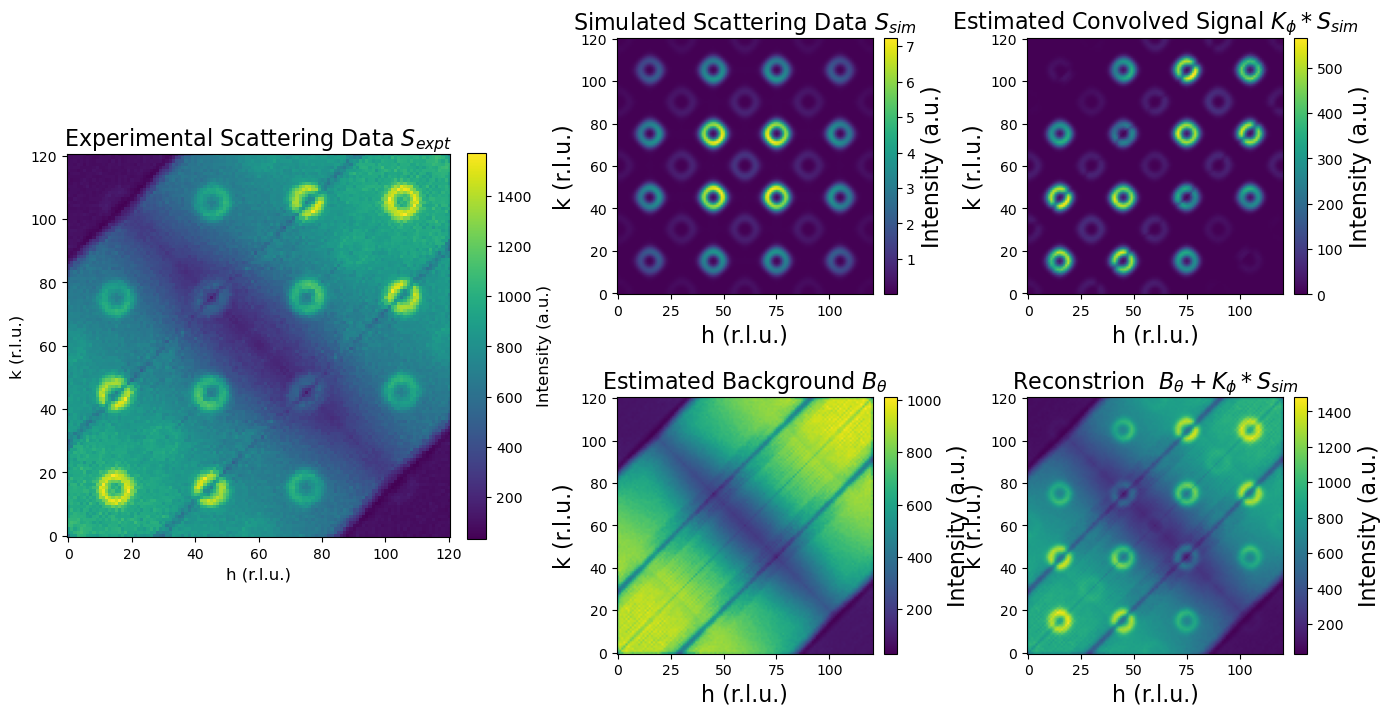

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Prepare the 2D arrays by reshaping and summing over the last two axes.
S_expt_plot = s_exp_full_2d[:,:,:,20:35].sum(-1).sum(-1)
S_sim_plot  = s_sim_full_2d[:,:,:,20:35].sum(-1).sum(-1)
S_sig_plot  = s_sig_full_2d[:,:,:,20:35].sum(-1).sum(-1)
S_bkg_plot  = s_bkg_full_2d[:,:,:,20:35].sum(-1).sum(-1)
recon_plot  = (s_sig_full_2d + s_bkg_full_2d)[:,:,:,20:35].sum(-1).sum(-1)

# Create a figure with a 2-row x 3-column GridSpec.
# The first column (spanning both rows) will host the large experimental plot.
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(nrows=2, ncols=3, width_ratios=[1.5, 1, 1], wspace=0.4, hspace=0.4)

# Big left panel: Experimental Scattering Data (spanning both rows)
ax_main = fig.add_subplot(gs[:, 0])
im_main = ax_main.imshow(S_expt_plot, origin='lower', aspect='auto', cmap='viridis')
ax_main.set_title(r"Experimental Scattering Data $S_{expt}$", fontsize=16)
ax_main.set_xlabel("h (r.l.u.)", fontsize=12)
ax_main.set_ylabel("k (r.l.u.)", fontsize=12)
cbar_main = plt.colorbar(im_main, ax=ax_main, fraction=0.046, pad=0.04)
cbar_main.set_label("Intensity (a.u.)", fontsize=12)

# Compute the aspect ratio from the image data (height / width)
aspect_ratio = S_expt_plot.shape[0] / S_expt_plot.shape[1]
# Try to set the axis box aspect to preserve the original image proportions
try:
    ax_main.set_box_aspect(aspect_ratio)
except Exception:
    ax_main.set_aspect(aspect_ratio)
# Center the axis content within its allocated grid cell
ax_main.set_anchor('C')

# Top-middle panel: Simulated Scattering Data S_sim
ax1 = fig.add_subplot(gs[0, 1])
im1 = ax1.imshow(S_sim_plot, origin='lower', aspect='auto', cmap='viridis')
ax1.set_title(r"Simulated Scattering Data $S_{sim}$", fontsize=16)
ax1.set_xlabel("h (r.l.u.)", fontsize=16)
ax1.set_ylabel("k (r.l.u.)", fontsize=16)
cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label("Intensity (a.u.)", fontsize=16)

# Top-right panel: Estimated Convolved Signal Component
ax2 = fig.add_subplot(gs[0, 2])
im2 = ax2.imshow(S_sig_plot, origin='lower', aspect='auto', cmap='viridis')
ax2.set_title(r"Estimated Convolved Signal $K_\phi * S_{sim}$", fontsize=16)
ax2.set_xlabel("h (r.l.u.)", fontsize=16)
ax2.set_ylabel("k (r.l.u.)", fontsize=16)
cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
cbar2.set_label("Intensity (a.u.)", fontsize=16)

# Bottom-middle panel: Estimated Background Component
ax3 = fig.add_subplot(gs[1, 1])
im3 = ax3.imshow(S_bkg_plot, origin='lower', aspect='auto', cmap='viridis')
ax3.set_title(r"Estimated Background $B_{\theta}$", fontsize=16)
ax3.set_xlabel("h (r.l.u.)", fontsize=16)
ax3.set_ylabel("k (r.l.u.)", fontsize=16)
cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
cbar3.set_label("Intensity (a.u.)", fontsize=16)

# Bottom-right panel: Reconstructed $S_{expt}$ = s_bkg + s_sig
ax4 = fig.add_subplot(gs[1, 2])
im4 = ax4.imshow(recon_plot, origin='lower', aspect='auto', cmap='viridis')
ax4.set_title(r"Reconstrion  $B_\theta + K_\phi * S_{sim}$", fontsize=16)
ax4.set_xlabel("h (r.l.u.)", fontsize=16)
ax4.set_ylabel("k (r.l.u.)", fontsize=16)
cbar4 = plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)
cbar4.set_label("Intensity (a.u.)", fontsize=16)

# # Save the composite figure using filenames based on your configuration.
# filename = f'composite_2row3col_clipped_nr{config["model_config"]["neighbor_range"]}_bkw{config["loss_bkg_mag_weight"]}_tvw{config["loss_bkg_TV_weight"]}'
# plt.savefig(f'{filename}.png', dpi=300, bbox_inches='tight')
# plt.savefig(f'{filename}.pdf', bbox_inches='tight')

plt.show()


Fourier Projection Slice

In [18]:
#Fourier Projection Slice 
proj_sig = np.sum(S_sig_plot, axis=0)
proj_sig_f = np.fft.fftshift(np.fft.fft(proj_sig))
slice_sig2 = np.fft.fftshift(np.fft.fft2(S_sig_plot))[S_sig_plot.shape[0] // 2]

proj_exp = np.sum(S_expt_plot, axis=0)
proj_exp_f = np.fft.fftshift(np.fft.fft(proj_exp))
slice_exp2 = np.fft.fftshift(np.fft.fft2(S_expt_plot))[S_expt_plot.shape[0] // 2]

proj_bkg = np.sum(S_bkg_plot, axis=0)
proj_bkg_f = np.fft.fftshift(np.fft.fft(proj_bkg))
slice_bkg2 = np.fft.fftshift(np.fft.fft2(S_bkg_plot))[S_bkg_plot.shape[0] // 2]

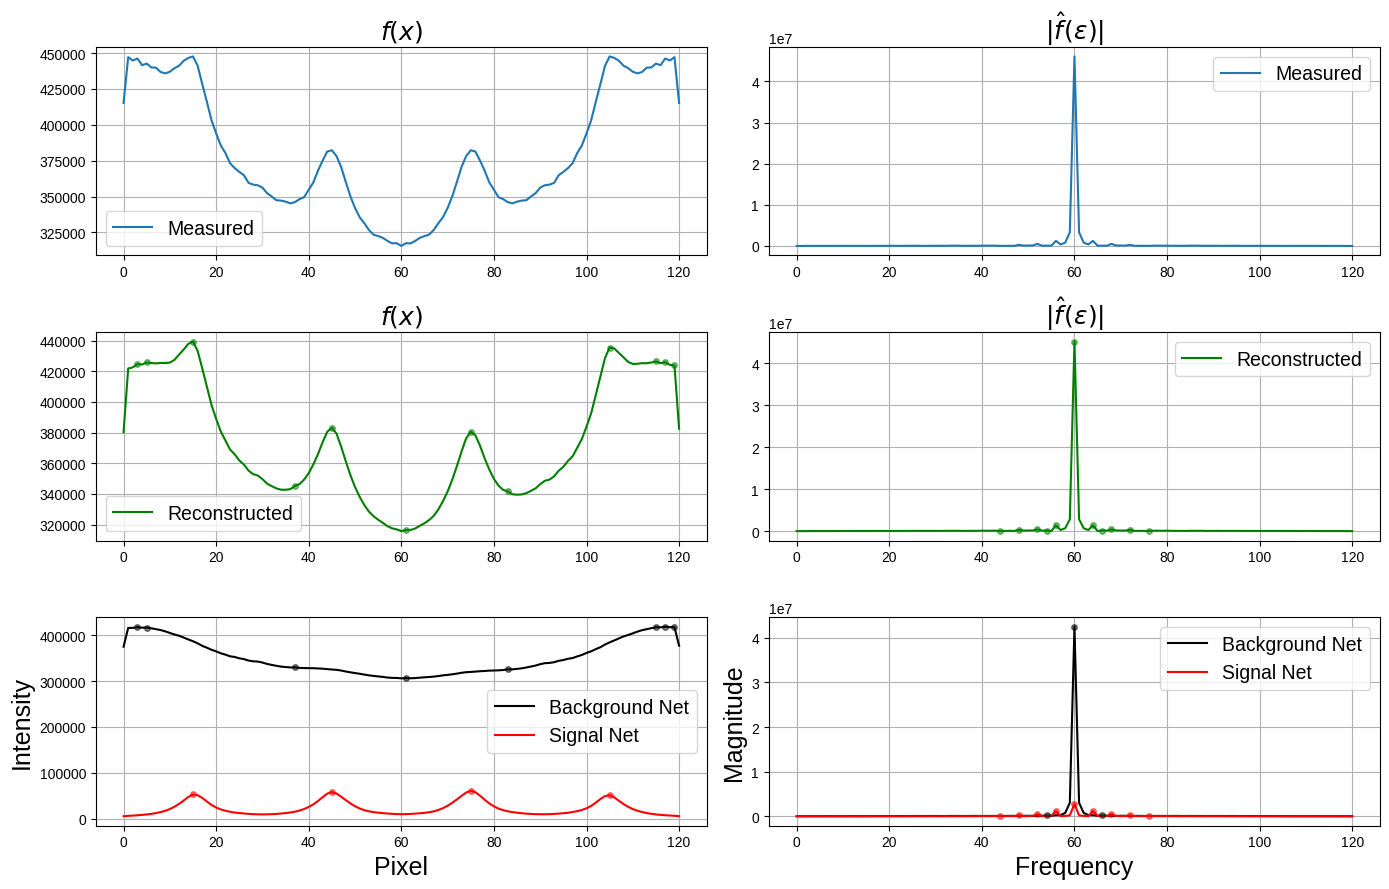

In [19]:
from scipy.signal import find_peaks
fig, axes = plt.subplots(3, 2, figsize=(14, 9))
# --- Truth
axes[0, 0].plot(proj_exp,label ='Measured')
axes[0, 0].set_title(r'$f(x)$', fontsize=18)
axes[0, 0].legend(fontsize=14)
axes[0, 1].plot(np.abs(slice_exp2),label ='Measured')
axes[0, 1].set_title(r'$|\hat f(\epsilon)|$', fontsize=18)
axes[0, 1].legend(fontsize=14)
# --- Top row: proj_bkg + proj_sig
axes[1, 0].plot(proj_bkg + proj_sig,color='green',label ='Reconstructed')
axes[1, 0].set_title(r'$f(x)$', fontsize=18)
axes[1, 0].legend(fontsize=14)
axes[1, 1].plot(np.abs(slice_bkg2 + slice_sig2),color='green',label ='Reconstructed')
axes[1, 1].set_title(r'$|\hat f(\epsilon)|$', fontsize=18)
axes[1, 1].legend(fontsize=14)
# --- Bottom row: proj_bkg and proj_sig separately (black and red)
axes[2, 0].plot(proj_bkg, color='black', label='Background Net')
axes[2, 0].plot(proj_sig, color='red', label='Signal Net')
axes[2, 0].set_xlabel('Pixel', fontsize=18)
axes[2, 0].set_ylabel('Intensity', fontsize=18)
axes[2, 0].legend(fontsize=14)
axes[2, 1].plot(np.abs(slice_bkg2), color='black', label='Background Net')
axes[2, 1].plot(np.abs(slice_sig2), color='red', label='Signal Net')
axes[2, 1].set_xlabel('Frequency', fontsize=18)
axes[2, 1].set_ylabel('Magnitude', fontsize=18)
axes[2, 1].legend( fontsize=14)

for ax in axes.flat:
    ax.grid(True)

### add local maxima

# --- Frequency domain (row 2, col 2) ---
mag_sig = np.abs(slice_sig2)
mag_bkg = np.abs(slice_bkg2)

idx1 = find_peaks(mag_sig, prominence=5e4)[0]
idx2 = find_peaks(mag_bkg, prominence=5e4)[0]
idx_union = np.union1d(idx1, idx2)

# Plot individual maxima
axes[2, 1].plot(idx1, mag_sig[idx1], 'ro', label='Signal Peak', alpha=0.5,markersize=4)
axes[2, 1].plot(idx2, mag_bkg[idx2], 'ko', label='Background Peak', alpha=0.5,markersize=4)

# Plot combined on reconstructed (row 1, col 2)
recon_freq = np.abs(slice_sig2 + slice_bkg2)
axes[1, 1].plot(idx_union, recon_freq[idx_union], 'go', label='Combined Peaks', alpha=0.5,markersize=4)

# --- Spatial domain (row 2, col 1) ---
idx1_spatial = find_peaks(proj_sig, prominence=5)[0]
idx2_spatial = find_peaks(proj_bkg, prominence=5)[0]
idx_union_spatial = np.union1d(idx1_spatial, idx2_spatial)

axes[2, 0].plot(idx1_spatial, proj_sig[idx1_spatial], 'ro', alpha=0.5,markersize=4)
axes[2, 0].plot(idx2_spatial, proj_bkg[idx2_spatial], 'ko', alpha=0.5,markersize=4)

recon_spatial = proj_sig + proj_bkg
axes[1, 0].plot(idx_union_spatial, recon_spatial[idx_union_spatial], 'go', alpha=0.5,markersize=4)
plt.style.use('seaborn-v0_8-white') 
plt.tight_layout()

# filename = f'fourier_projection_slice_nr{config["model_config"]["neighbor_range"]}_bkw{config["loss_bkg_mag_weight"]}_tvw{config["loss_bkg_TV_weight"]}'
# plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
plt.show()